# Import

In [ ]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install --upgrade pip
    !pip install -q arviz
    !pip install --upgrade pymc3
    !pip install causalgraphicalmodels
    !pip install -q watermark
    !pip install --upgrade daft

In [2]:
%load_ext watermark

In [3]:
%watermark -p daft,causalgraphicalmodels

daft 0.0.4
causalgraphicalmodels 0.0.4


In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import daft
from causalgraphicalmodels import CausalGraphicalModel
import logging

BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

def precis(trace, var_names=None):
  s = az.summary(trace, hdi_prob=0.89, round_to=2, var_names=var_names)
  return s[['mean', 'sd', 'hdi_5.5%','hdi_94.5%']]

def scale(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, disable_progress_bar=True):
    
    logger = logging.getLogger('pymc3')
    logger.setLevel(logging.ERROR)

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc3

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            testval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True, progressbar = disable_progress_bar==False)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(
        stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1)
    )

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(
        stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1)
    )

    logger.setLevel(logging.DEBUG)

    return np.mean(dev_train), np.mean(dev_test)


%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 7 Ulysses Compass

Video Lecture 7: https://www.youtube.com/watch?v=0Jc6Kgw5qc0&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=7&ab_channel=RichardMcElreath

Video Lecture 8: https://www.youtube.com/watch?v=gjrsYDJbRh0&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=8&ab_channel=RichardMcElreath

All credit goes to the following sources. My work has been minor here. This is more about understanding the concept and trying to reproduce the code. Whenever I get stuck, I would look here.

Code originally from: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_07.ipynb

## 7.1 The problem with parameters

### Code 7.1

In [ ]:
d = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


### Code 7.2

In [ ]:
d['mass_std'] = scale(d['mass'])
d['brain_std'] = d['brain'] / max(d.brain)

### Code 7.3

In [ ]:
with pm.Model() as m_7_1:
  a = pm.Normal('a', 0.5, 1)
  b = pm.Normal('b', 0, 10)
  mu = a + b*d.mass_std
  log_sigma = pm.Normal('log_sigma', 0, 1)
  brain_std = pm.Normal('brain_std', mu, np.exp(log_sigma), observed=d.brain_std)

  m_7_1_trace= pm.sample()

precis(m_7_1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.53,0.13,0.37,0.70
b,0.17,0.11,-0.01,0.34
log_sigma,-1.40,0.39,-1.98,-0.81


In [ ]:
m_7_1_OLS = smf.ols("brain_std ~ mass_std", data=d).fit()
m_7_1_OLS.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Wed, 04 Nov 2020   Prob (F-statistic):             0.0798
Time:                        14:42:21   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Intercept = 0.5287 vs "a" = 0.53
# mass_std = 0.1671 vs "b" = 0.17

### Code 7.4

In [ ]:
p, cov = np.polyfit(d["mass_std"], d["brain_std"], 1, cov=True)
post = stats.multivariate_normal(p, cov).rvs(1000)

precis({'b':post.T[0], 'a':post.T[1]})

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%
b,0.17,0.07,0.06,0.29
a,0.53,0.07,0.43,0.65


### Code 7.5

In [ ]:
1 - m_7_1_OLS.resid.var() / d.brain_std.var()

0.490158047949084

### Code 7.6

In [ ]:
def R2_is_bad(m):
  return 1 - m.resid.var() / d.brain_std.var()

R2_is_bad(m_7_1_OLS)

0.490158047949084

### Code 7.7 + 7.8 + 7.9

In [ ]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=d).fit()
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=d).fit()
m_7_4 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)", data=d).fit()
m_7_5 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)", data=d).fit()
m_7_6 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)", data=d).fit()

### Code 7.10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


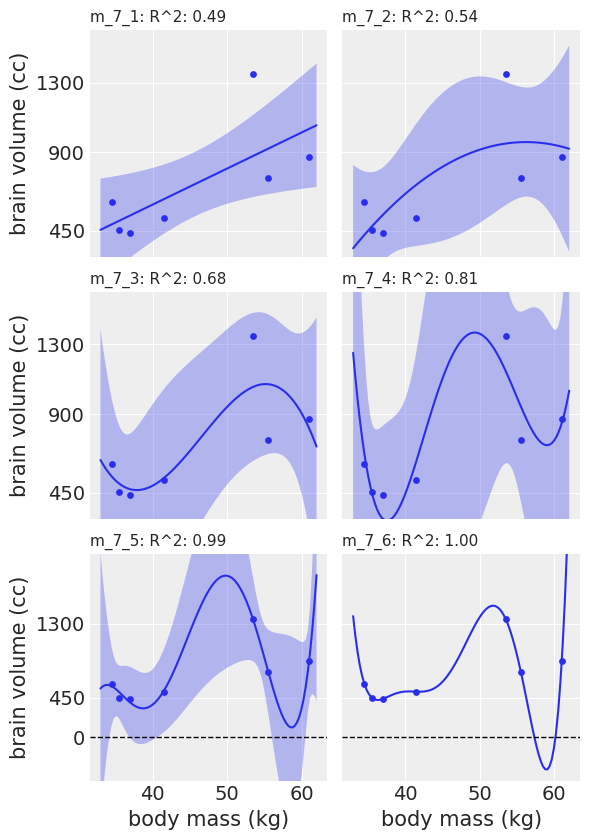

In [ ]:
models = [m_7_1_OLS, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - d.mass.mean()) / d.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * d.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(d.mass, d.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

### Code 7.11

In [ ]:
d_minus_1 = d.drop(d.index[-1])
d_minus_1

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185


### Figure 7.4

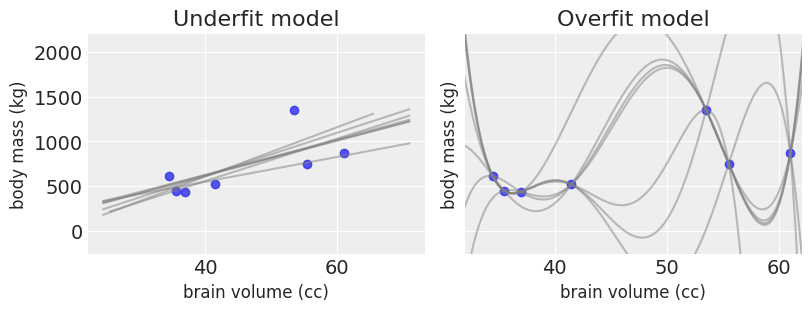

In [ ]:

# Figure 7.4

# this code taken from PyMC3 port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit() # need to calculate regression line
    x_pred = pd.DataFrame({"mass": np.linspace(d_new.mass.min() - 10, d_new.mass.max() + 10, 50)})  # create linspace dataframe
    y_pred = m0.predict(x_pred)  # calculate predicted values
    
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new).fit()
    x_pred = pd.DataFrame({"mass": np.linspace(d_new.mass.min() - 10, d_new.mass.max() + 10, 200)})  # create linspace dataframe
    y_pred = m1.predict(x_pred)  # calculate predicted values from fitted model
    
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

## 7.2 Entropy and accuracy

### Code 7.12

In [ ]:
p = np.array([0.3, 0.7])
-np.sum(p*np.log(p)).round(7)

0.6108643

### Code 7.13 + Code 7.14

In [ ]:
n_samples = 3000

intercept, slope = (
    stats.multivariate_normal(m_7_1_OLS.params, m_7_1_OLS.cov_params()).rvs(n_samples).T
)

pred = intercept + slope * d.mass_std.values.reshape(-1, 1)

n, ns = pred.shape

In [ ]:
# PyMC3 does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (np.sum((pred - d.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(d.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.62188172,  0.6603106 ,  0.55727075,  0.62848902,  0.47177962,
        0.43929562, -0.84323986])

### Code 7.15

In [ ]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, data, ref_col, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(model.model.data.design_info, data, return_type="dataframe").values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (
        np.sum((pred - data[ref_col].values.reshape(-1, 1)) ** 2, 0) / 7
    ) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(data[ref_col], pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [ ]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [d] * len(models[:-1]), ['brain_std']* len(models[:-1]), [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.52637218,  2.34434624,  2.84208464,  3.55100265, 11.169609  ])

### Code 7.16

In [ ]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in tqdm(range(2, param + 1)):
    print('calculating param {}'.format(j))
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

calculating param 2


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


calculating param 3
calculating param 4
calculating param 5
calculating param 6



### Code 7.18 / Figure 7.7

In [ ]:
r

array([[55.75867238,  1.24346605, 55.44415218,  4.56863494],
       [56.90124374,  3.71166065, 55.84803605,  4.20572391],
       [56.63667987,  3.5118569 , 56.05264809,  5.08515464],
       [56.70903547,  3.23046141, 56.65257736,  5.67558556],
       [56.6151436 ,  3.15266279, 57.08621781,  5.68675663]])

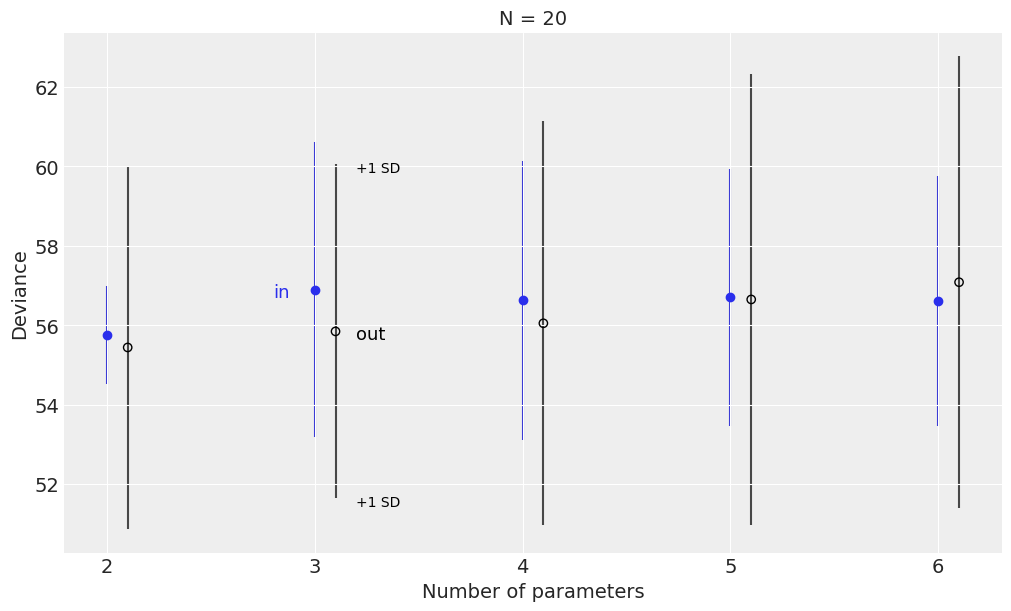

In [ ]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title("N = {}".format(n), fontsize=14)
plt.show()

## 7.3 Golem Taming

In [ ]:
# no code

## 7.4 Predicting predictive accuracy

### Code 7.19

In [ ]:
cars = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/cars.csv', sep=',', index_col=0)
cars.head()

,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


In [ ]:
with pm.Model() as m:
  sigma = pm.Exponential('sigma', 1)
  b = pm.Normal('b', 0, 10)
  a = pm.Normal('a', 0, 100)
  mu = pm.Deterministic('mu', a + b*cars.speed)
  dist = pm.Normal('dist', mu, sigma, observed=cars.dist)

  m_trace = pm.sample(1000, tune=10000)

Applied log-transform to sigma and added transformed sigma_log__ to model.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b, sigma]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 47 seconds.


In [ ]:
precis(m_trace)

### Code 7.20

In [ ]:
n_samples = 1000
n_cases = cars.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = m_trace["a"][s] + m_trace["b"][s] * cars["speed"]
    p_ = stats.norm.logpdf(cars["dist"], loc=mu, scale=m_trace["sigma"][s])
    logprob[:, s] = p_

### Code 7.21 + 7.22 + 7.23

In [ ]:
n_cases = cars.shape[0]
lppd = [logsumexp(logprob[i, ]) - np.log(n_samples) for i in range(1, n_cases)]
pWAIC = [np.var(logprob[i,]) for i in range(1, n_cases)]
-2 * (sum(lppd) - sum(pWAIC))

413.97749853553864

### Code 7.24

In [ ]:
waic_vec = -2 * (np.array(lppd) - np.array(pWAIC))
np.sqrt(n_cases * np.var(waic_vec))

16.34558381923513

## 7.5 Model Comparison 

### Code 7.25

In [8]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict(
    {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}
)

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bf, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8943454643448137, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
az.waic(m_6_7_trace, m_6_7, scale="deviance")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   328.16    16.18
p_waic            4.29        -

There has been a warning during the calculation. Please check the results.

### Code 7.26

In [10]:
compare_df = az.compare(
    {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace,},
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,328.165,4.28941,0,1,16.1785,0,True,deviance
m_6_8,1,391.508,2.89164,63.3429,1.75897e-14,13.5603,14.5123,True,deviance
m_6_6,2,403.721,1.84224,75.5567,3.9181e-17,12.4459,16.0566,False,deviance


In [11]:
compare_df = az.compare(
    {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace,},
    method="pseudo-BMA",
    ic="loo",
    scale="deviance",
)
compare_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_6_7,0,328.175,4.29431,0,1,16.1716,0,False,deviance
m_6_8,1,391.515,2.89516,63.3402,1.7614e-14,13.5636,14.5082,False,deviance
m_6_6,2,403.723,1.8432,75.5488,3.93357e-17,12.4465,16.0504,False,deviance


### Code 7.27

In [12]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")
diff_m6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i
n = len(waic_m_6_8.waic_i)
np.sqrt(n * np.var(diff_m6_7_m_6_8))

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


<xarray.DataArray 'waic_i' ()>
array(14.51228948)

### Code 7.28

In [13]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

### Code 7.29

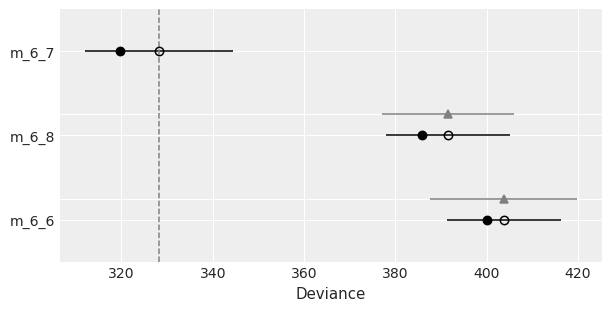

In [14]:
az.plot_compare(compare_df);

### Code 7.30

In [15]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale='deviance').waic_i
diff_m6_6_m6_8 = waic_m_6_6 - waic_m_6_8.waic_i
np.sqrt(n * np.var(diff_m6_6_m6_8))

<xarray.DataArray 'waic_i' ()>
array(9.0748882)

### Code 7.31

In [16]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterio

,m_6_7,m_6_8
m_6_8,14.5123,0
m_6_6,16.0566,9.07489


### Code 7.32

In [17]:
d = pd.read_csv(BASE_URL + "/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [18]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_3_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Code 7.33

In [19]:
az.compare({'m5.1':m_5_1_trace, 'm5.2':m_5_2_trace, 'm5.3':m_5_3_trace}, scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5.1,0,126.931,3.69953,0,0.65698,12.1156,0,False,deviance
m5.3,1,128.759,4.79141,1.8275,0.275655,9.50848,0.683019,False,deviance
m5.2,2,140.388,2.98879,13.4565,0.0673646,12.1472,9.13085,False,deviance


In [20]:
az.compare({'m5.1':m_5_1_trace, 'm5.2':m_5_2_trace, 'm5.3':m_5_3_trace}, scale='deviance', ic='waic')

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterio

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5.1,0,126.881,3.67443,0,0.640725,13.2783,0,True,deviance
m5.3,1,128.582,4.70283,1.70054,0.28127,10.2079,0.689224,True,deviance
m5.2,2,140.327,2.95828,13.4457,0.0780046,13.2176,9.10592,True,deviance


### Code 7.34

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


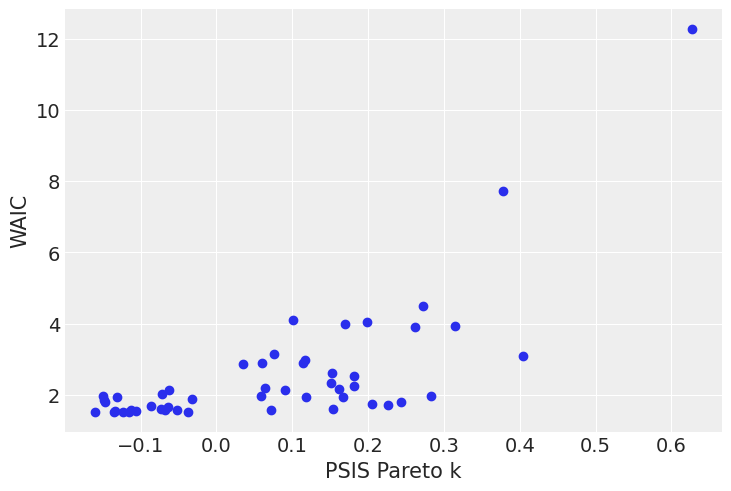

In [21]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

### Code 7.35

In [32]:
with pm.Model() as m5_3t:
  a = pm.Normal('a', 0, 0.2)
  bA = pm.Normal('bA', 0, 0.5)
  bM = pm.Normal('bM', 0, 0.5)
  
  mu = a + bA * d['A'] + bM * d['M'] 
  sigma = pm.Exponential('sigma', 1)

  D = pm.StudentT('D', 2, mu, sigma, observed=d['D'])

  m5_3t_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [30]:
precis(m5_3_trace)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.02,0.10,-0.16,0.18
bA,-0.69,0.15,-0.94,-0.46
bM,0.04,0.20,-0.25,0.38
sigma,2.71,0.75,1.49,3.77


In [31]:
az.loo(m5_3_trace)

Computed from 2000 by 50 log-likelihood matrix

         Estimate       SE
elpd_loo   -66.63     5.33
p_loo        5.37        -

In [38]:
compare_df = az.compare({'m5_3t':m5_3t_trace, 'm5_3': m_5_3_trace}, scale='deviance')
compare_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_3,0,128.759,4.79141,0,0.765007,10.2685,0,False,deviance
m5_3t,1,133.201,5.30751,4.44245,0.234993,12.4602,5.65501,False,deviance


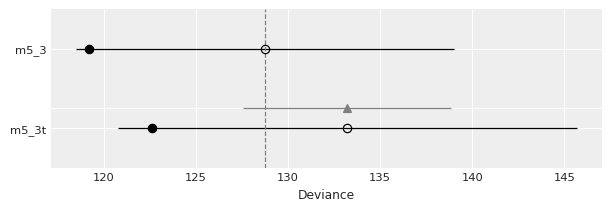

In [39]:
az.plot_compare(compare_df)

# Homework

Link to Homework: https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week04.pdf

Link to Solutions: https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week04_solutions.pdf

Link to Solutions in Python: https://github.com/gbosquechacon/statrethink_course_in_pymc3/blob/master/notebooks/pymc3/rethink_stats_pymc3_w04.ipynb

## HW1

Consider three fictional Polynesian islands. On each there is a Royal ornithologist charged by the kinf with surveying the birb population. They have each found the following proportions of 5 important birb species:

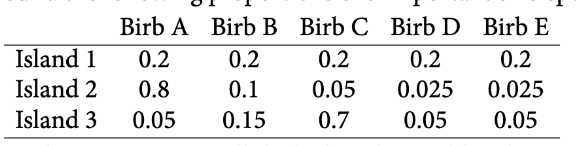

Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. 
<br> First, compute the entropy of each island's birb distribution. Interpret these entropy values.
<br>Second, use each island's birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. >ou should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?

In [44]:
birds = pd.DataFrame([[0.2, 0.2, 0.2, 0.2, 0.2],
[0.8, 0.1, 0.05, 0.025, 0.025],
[0.05, 0.15, 0.7, 0.05, 0.05]], columns=['A', 'B', 'C', 'D', 'E'])
birds

,A,B,C,D,E
0,0.20,0.20,0.20,0.200,0.200
1,0.80,0.10,0.05,0.025,0.025
2,0.05,0.15,0.70,0.050,0.050


## 1.1 First Part

Function for Entropy:

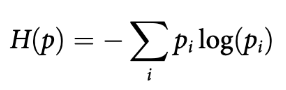

In [68]:
e = []
for row in range(len(birds)):
 e.append(-round ( sum([p*np.log(p) for p in birds.loc[row].values]), 5 ) )
e

[1.60944, 0.743, 0.9836]

Entropy is the highest on island 1, because all probabilities are same likely. The chance of being surprised is very low, as the expectation is even anyway.
<br> Entropy on island 2 is the lowest as we have very different probabilites. The chance to find A is the highest and the surprise would be big to find something else.

## 1.2 Second Part

K-L-Divergence Function:

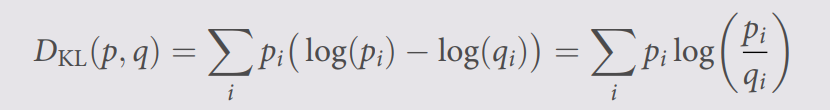

In [58]:
birds

,A,B,C,D,E
0,0.20,0.20,0.20,0.200,0.200
1,0.80,0.10,0.05,0.025,0.025
2,0.05,0.15,0.70,0.050,0.050


In [66]:
result = []
for p_val in range(3):
  row = []
  for q_val in range(3):
    row.append(sum( [p*np.log(p / q) for p, q in zip(birds.loc[p_val].values, birds.loc[q_val].values)] ))
  result.append(row)

island_order = ['island1', 'island2', 'island3']
df_r = pd.DataFrame(result, columns=island_order)
df_r['island'] = island_order
df_r = df_r.set_index('island')
df_r

,island1,island2,island3
island,,,
island1,0.000000,0.970406,0.638760
island2,0.866434,0.000000,2.010914
island3,0.625838,1.838845,0.000000


island1 predicts the other best, because it expects all birds equally distributed. While the other two make even contradictory asumptions and there predict each other very different. 

In [69]:
df_r['entropy'] = e
df_r

,island1,island2,island3,entropy
island,,,,
island1,0.000000,0.970406,0.638760,1.60944
island2,0.866434,0.000000,2.010914,0.74300
island3,0.625838,1.838845,0.000000,0.98360


The higher the entropy, the less a model is surprised by unlikely values

## HW2

Recall the marriage, age and happiness collide bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, the will produce identical results). Which model is expected to make better perdictions? Whcih model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

In [90]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = (
            np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        )
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

d = sim_happiness()

d["married"] = d["married"].astype(int)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(d.to_dict(orient="list"), kind="stats", round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


In [91]:
d2 = d[d.age > 17] # only adults
d2['A'] = (d2['age'] - 18) / (65 - 18)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
mid = pd.Categorical(d2.loc[:, "married"].astype(int))

with pm.Model() as m_6_9:
  a = pm.Normal('a', 0, 1, shape=2)
  bA = pm.Normal('bA', 0, 2)
  sigma = pm.Exponential('sigma', 1)
  
  mu = a[mid] + bA*d2.A.values
  happiness = pm.Normal('happiness', mu, sigma, observed=d2.happiness.values)

  m_6_9_trace = pm.sample()

az.summary(m_6_9_trace, hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.30,-0.08,0.0,0.0,877.27,857.96,878.19,1011.29,1.00
a[1],1.21,0.09,1.05,1.35,0.0,0.0,892.45,890.92,887.81,992.73,1.00
bA,-0.71,0.13,-0.90,-0.50,0.0,0.0,809.92,809.25,812.95,1002.21,1.00
sigma,1.02,0.02,0.99,1.06,0.0,0.0,1087.58,1084.55,1091.08,1214.42,1.01


In [94]:
with pm.Model() as m_6_10:
  a = pm.Normal('a', 0, 1)
  bA = pm.Normal('bA', 0, 2)
  sigma = pm.Exponential('sigma', 1)
  
  mu = a + bA*d2.A
  happiness = pm.Normal('happiness', mu, sigma, observed=d2.happiness)

  m_6_10_trace = pm.sample()

az.summary(m_6_10_trace, hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.01,0.08,-0.13,0.13,0.0,0.0,780.07,701.58,781.67,821.65,1.01
bA,0.01,0.14,-0.21,0.24,0.0,0.0,845.62,750.42,846.42,951.29,1.01
sigma,1.22,0.03,1.17,1.26,0.0,0.0,1113.07,1113.07,1112.91,837.24,1.00


In [99]:
df_compare = az.compare({'m6_9':m_6_9_trace, 'm6_10':m_6_10_trace}, ic='waic', scale='deviance')
df_compare

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_9,0,2711.29,3.80776,0,1,36.6226,0,False,deviance
m6_10,1,3037.82,2.54313,326.528,1.54544e-50,27.2597,32.9997,False,deviance


Model 6.9 takes two groups: Married and nonMarried and checks the influence of Age on Happiness

Model 6.10 uses only age and checks its influence on happiness.

As there is an collider path, conditioning on marriage will give wrong association. Of cource, it will predict better, but it will be wrong.

## HW3

Reconside the urban fox analysis from last weeks homework. Use WAIC or LOO based model comparison on five different models, each using weight as the outcome, and containing these sets of predictor variables:
<br>1) avgfood + groupsize + area
<br>2) avgfood + groupsize
<br>3) groupsize + area
<br>4) avgfood
<br>5) area

Can you explain the relative differences in WAIC scores, using the fox DAG from last weeks homework? Be sure to pay attention to the standard error of the score deiffrences (dSE)

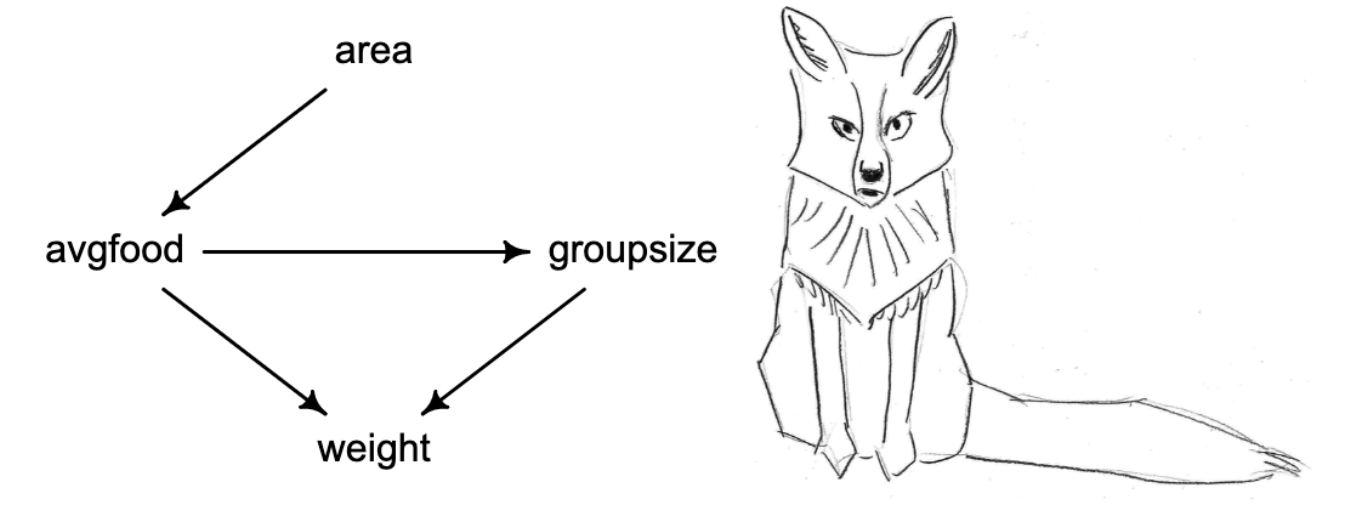

In [101]:
d_foxes = pd.read_csv(BASE_URL + "/foxes.csv", sep=";")
d_foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [104]:
d_foxes['W'] = scale(d_foxes.weight)
d_foxes['A'] = scale(d_foxes.area)
d_foxes['F'] = scale(d_foxes.avgfood)
d_foxes['G'] = scale(d_foxes.groupsize)

In [106]:
with pm.Model() as mhw3_1:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5)
  bA = pm.Normal('bA', 0, 1)
  bG = pm.Normal('bG', 0, 1)
  bF = pm.Normal('bF', 0, 1)

  mu = a + bA*d_foxes.A + bG*d_foxes.G + bF*d_foxes.F
  W = pm.Normal('W', mu, sigma, observed=d_foxes.W)

  mhw3_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bF, bG, bA, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [107]:
with pm.Model() as mhw3_2:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5)
  bG = pm.Normal('bG', 0, 1)
  bF = pm.Normal('bF', 0, 1)

  mu = a + bG*d_foxes.G + bF*d_foxes.F
  W = pm.Normal('W', mu, sigma, observed=d_foxes.W)

  mhw3_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bF, bG, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9011747266112721, but should be close to 0.8. Try to increase the number of tuning steps.


In [108]:
with pm.Model() as mhw3_3:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5)
  bA = pm.Normal('bA', 0, 1)
  bG = pm.Normal('bG', 0, 1)

  mu = a + bA*d_foxes.A + bG*d_foxes.G
  W = pm.Normal('W', mu, sigma, observed=d_foxes.W)

  mhw3_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bG, bA, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [109]:
with pm.Model() as mhw3_4:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5)
  bF = pm.Normal('bF', 0, 1)

  mu = a + bF*d_foxes.F
  W = pm.Normal('W', mu, sigma, observed=d_foxes.W)

  mhw3_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bF, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [110]:
with pm.Model() as mhw3_5:
  sigma = pm.Exponential('sigma', 1)
  a = pm.Normal('a', 0, 0.5)
  bA = pm.Normal('bA', 0, 1)

  mu = a + bA*d_foxes.A
  W = pm.Normal('W', mu, sigma, observed=d_foxes.W)

  mhw3_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bA, a, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [112]:
az.compare({'f_g_a':mhw3_1_trace,
            'f_g':mhw3_2_trace, 
            'g_a':mhw3_3_trace, 
            'f':mhw3_4_trace, 
            'a':mhw3_5_trace}
           , ic='waic'
           , scale='deviance')

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/us

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
f_g_a,0,323.193,4.97059,0,0.255656,16.0198,0,True,deviance
f_g,1,323.317,3.67644,0.124355,0.371081,15.6772,3.62701,True,deviance
g_a,2,323.607,3.6139,0.414492,0.316504,15.5426,3.64357,True,deviance
f,3,333.628,2.4381,10.4348,0.0292281,13.2689,7.86009,False,deviance
a,4,333.936,2.6946,10.7426,0.0275303,13.365,7.90291,False,deviance
